In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from sklearn import ensemble, metrics, model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score 
import warnings
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pickle
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import re

# Morphometric-based

In [2]:
berlin_s1 = pd.read_csv(r"results\berlin_S1_results.csv", index_col=[0, 1])
hongkong_s1 = pd.read_csv(r"results\hongkong_S1_results.csv", index_col=[0, 1])
paris_s1 = pd.read_csv(r"results\paris_S1_results.csv", index_col=[0, 1])
rome_s1 = pd.read_csv(r"results\rome_S1_results.csv", index_col=[0, 1])
saopaulo_s1 = pd.read_csv(r"results\saopaulo_S1_results.csv", index_col=[0, 1])

C:\Users\Markéta\AppData\Local\Temp\ipykernel_28040\1884841739.py:54: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.8}` instead.

  sns.barplot(x='Location', y='Score', hue='Metric', data=melted_df,


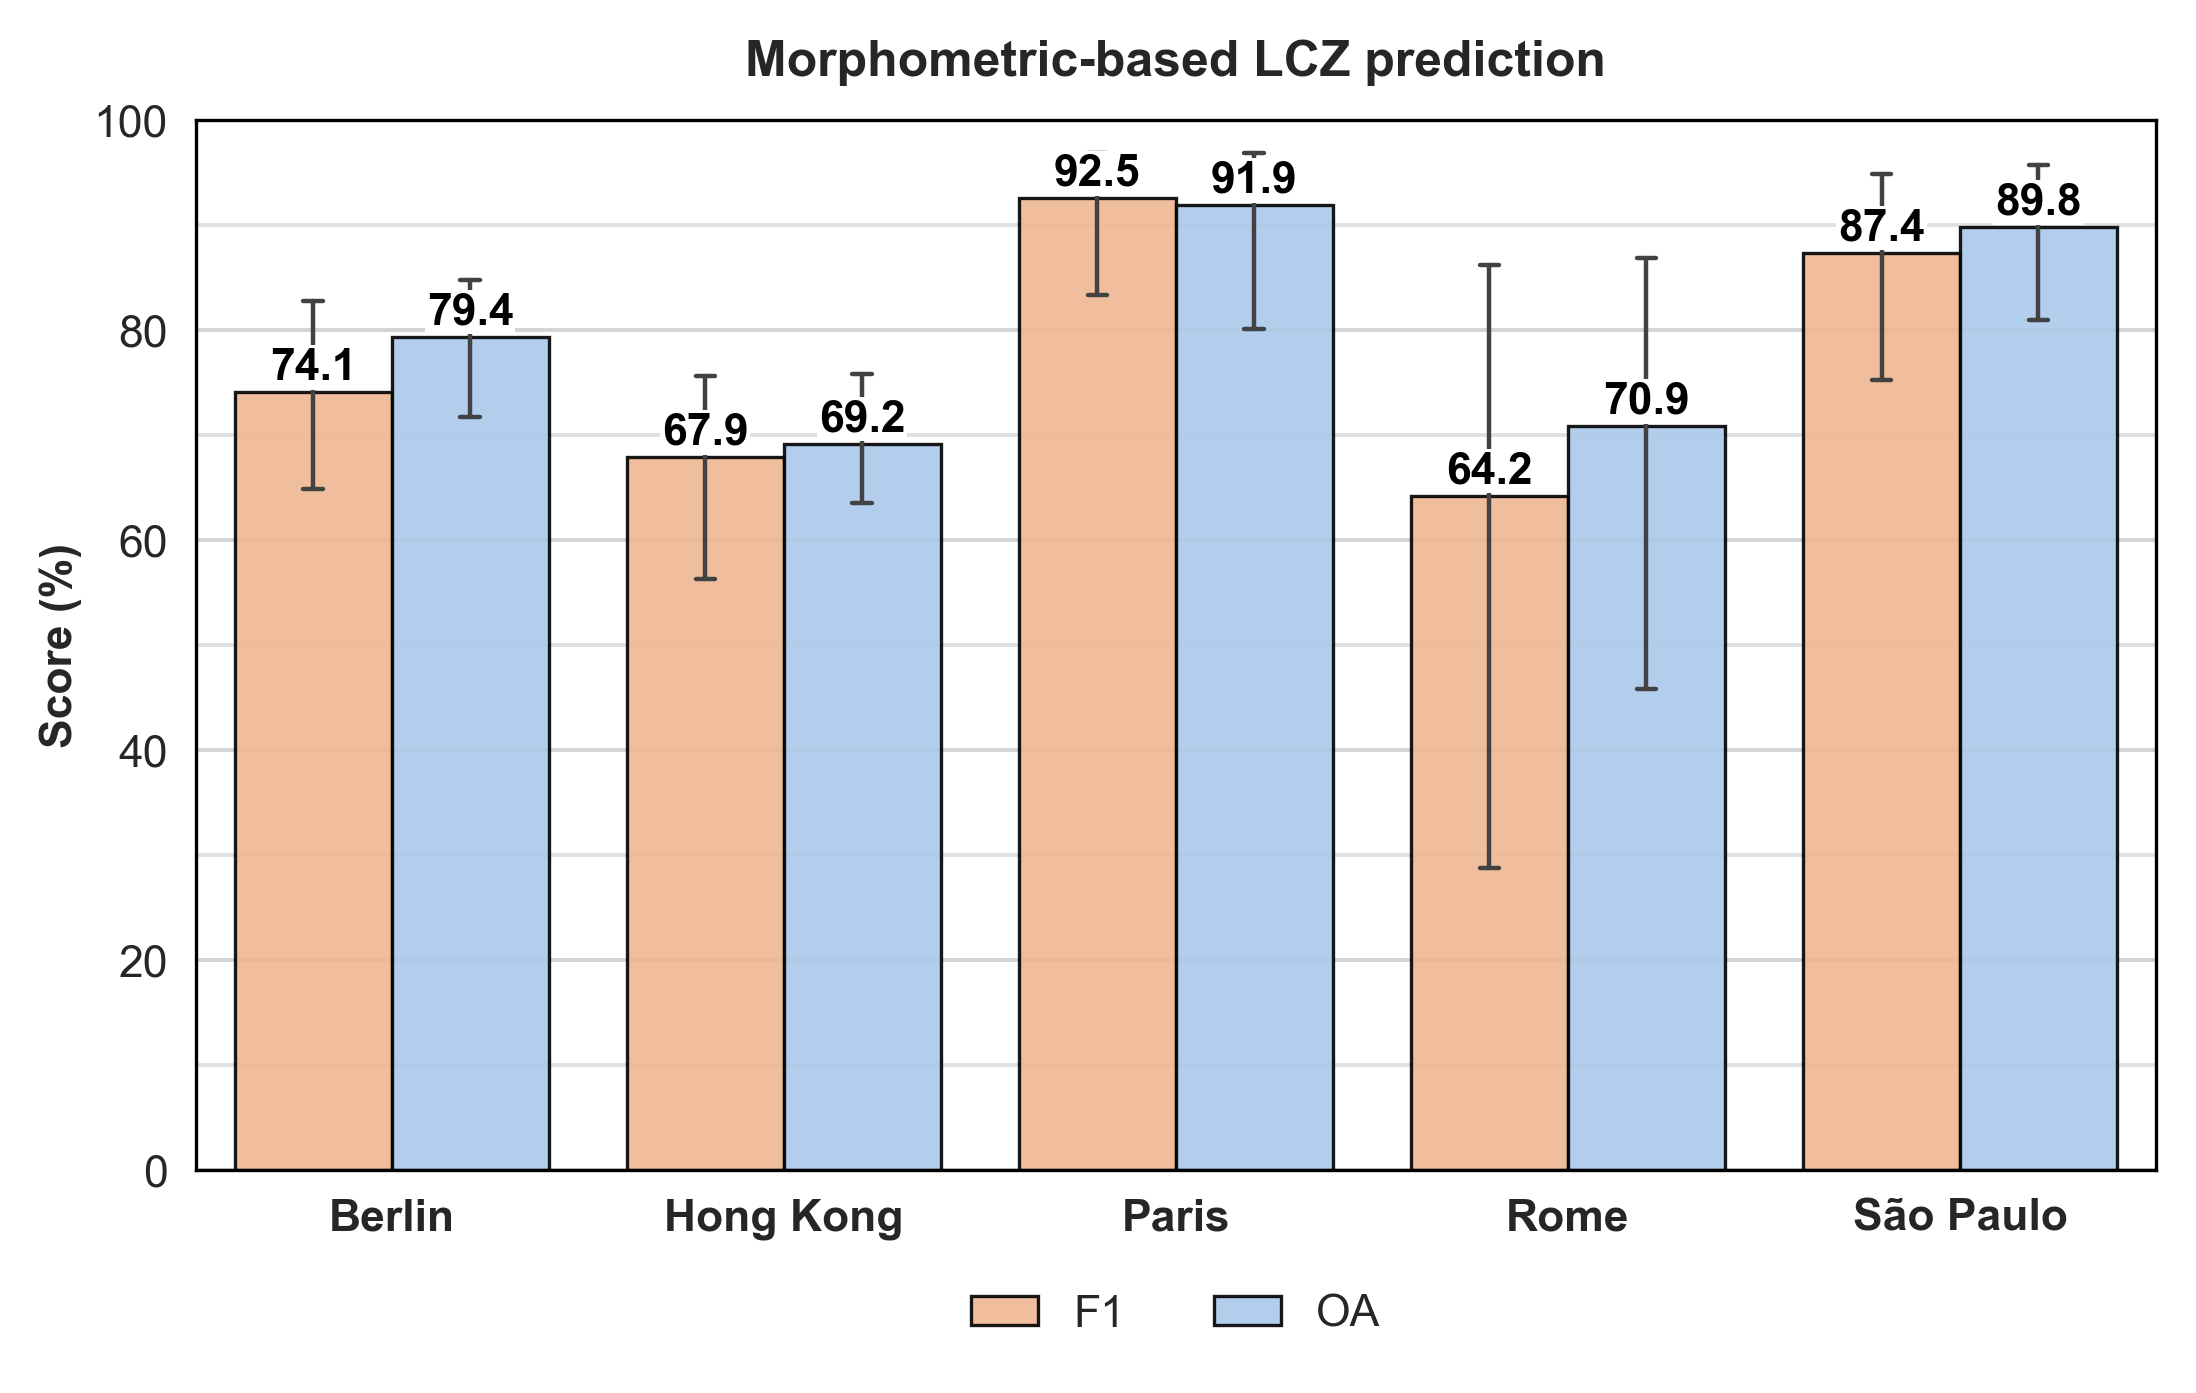

In [5]:
FIG_WIDTH = 5.5  
FIG_HEIGHT = 3.5

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'lines.linewidth': 0.8,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.5,
})

locations_data = {
    'Berlin': berlin_s1,
    'Hong Kong': hongkong_s1,
    'Paris': paris_s1,
    'Rome': rome_s1,
    'São Paulo': saopaulo_s1
}

best_results = []
location_order = sorted(locations_data.keys()) 

for loc_name in location_order:
    df = locations_data[loc_name]
    strategy_means = df.groupby(level=0)['wF1'].mean()
    best_strategy = strategy_means.idxmax()
    
    winner_df = df.xs(best_strategy, level=0, drop_level=False).copy().reset_index()
    winner_df['Location'] = loc_name
    best_results.append(winner_df[['Location', 'Fold', 'OA', 'wF1']])

final_plot_df = pd.concat(best_results, ignore_index=True)
melted_df = final_plot_df.melt(id_vars=['Location', 'Fold'], 
                               value_vars=['OA', 'wF1'], 
                               var_name='Metric', 
                               value_name='Score')

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=400)
sns.set_style("whitegrid")

custom_colors = [sns.color_palette("pastel")[1], sns.color_palette("pastel")[0]]

sns.barplot(x='Location', y='Score', hue='Metric', data=melted_df, 
            hue_order=['wF1', 'OA'], 
            palette=custom_colors, 
            errorbar=('pi', 100), 
            capsize=0.1, 
            errwidth=0.8, 
            alpha=0.9,
            edgecolor='black',
            linewidth=0.6,
            ax=ax,
           zorder=1)

metric_order = ['wF1', 'OA']

for i, container in enumerate(ax.containers):
    metric_name = metric_order[i]
    
    for j, bar in enumerate(container):
        loc_name = location_order[j]
        
        subset = melted_df[(melted_df['Location'] == loc_name) & (melted_df['Metric'] == metric_name)]
        val_mean = subset['Score'].mean()
        
        x_pos = bar.get_x() + bar.get_width() / 2
        
        ax.text(x_pos, val_mean + 0.4, f'{val_mean:.1f}', 
                ha='center', va='bottom', fontsize=8, fontweight='bold', 
                color='black', zorder=20, clip_on=False, rotation=0,
                bbox=dict(facecolor='white', edgecolor='none', pad=.3, alpha=1))

ax.set_title('Morphometric-based LCZ prediction', fontsize=9, fontweight='bold', pad=8)
ax.set_ylabel('Score (%)', fontsize=8, fontweight='bold', labelpad=2)
ax.set_xlabel('')

ax.tick_params(axis='both', which='major', pad=1.5)
plt.yticks(np.arange(0, 101, 20), fontsize=8)
plt.xticks(fontsize=8, rotation=0, fontweight='bold')

ax.set_ylim(0, 100) 

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=1.0, linewidth=0.7)
for spine in ax.spines.values():
    spine.set_linewidth(0.6)
    spine.set_color('black')

for y_val in [10,30,50,70, 90]:
    ax.axhline(y=y_val, color='lightgrey', linewidth=0.7, alpha=0.7, zorder=0)

for spine in ax.spines.values():
    spine.set_linewidth(0.6)
    spine.set_color('black')

# Legend
handles, _ = ax.get_legend_handles_labels()
new_labels = [r"F1", "OA"]
ax.legend(handles, new_labels, 
          loc='upper center', 
          bbox_to_anchor=(0.5, -0.08), 
          ncol=2, 
          fontsize=8, 
          frameon=False, 
          handlelength=1.5, 
          handleheight=0.6)

plt.tight_layout()
plt.savefig(r'figures\figure_5.jpg', dpi=1000, bbox_inches='tight')
plt.show()

# S1 Confusion Matrices

In [6]:
berlin_s1 = pd.read_csv(r"results\berlin_S1_results.csv", index_col=[0, 1])
berlin_s1_cm = np.load(r"results\berlin_S1_summed_cm.npy")

hongkong_s1 = pd.read_csv(r"results\hongkong_S1_results.csv", index_col=[0, 1])
hongkong_s1_cm = np.load(r"results\hongkong_S1_summed_cm.npy")

paris_s1 = pd.read_csv(r"results\paris_S1_results.csv", index_col=[0, 1])
paris_s1_cm = np.load(r"results\paris_S1_summed_cm.npy")

rome_s1 = pd.read_csv(r"results\rome_S1_results.csv", index_col=[0, 1])
rome_s1_cm = np.load(r"results\rome_S1_summed_cm.npy")

saopaulo_s1 = pd.read_csv(r"results\saopaulo_S1_results.csv", index_col=[0, 1])
saopaulo_s1_cm = np.load(r"results\saopaulo_S1_summed_cm.npy")

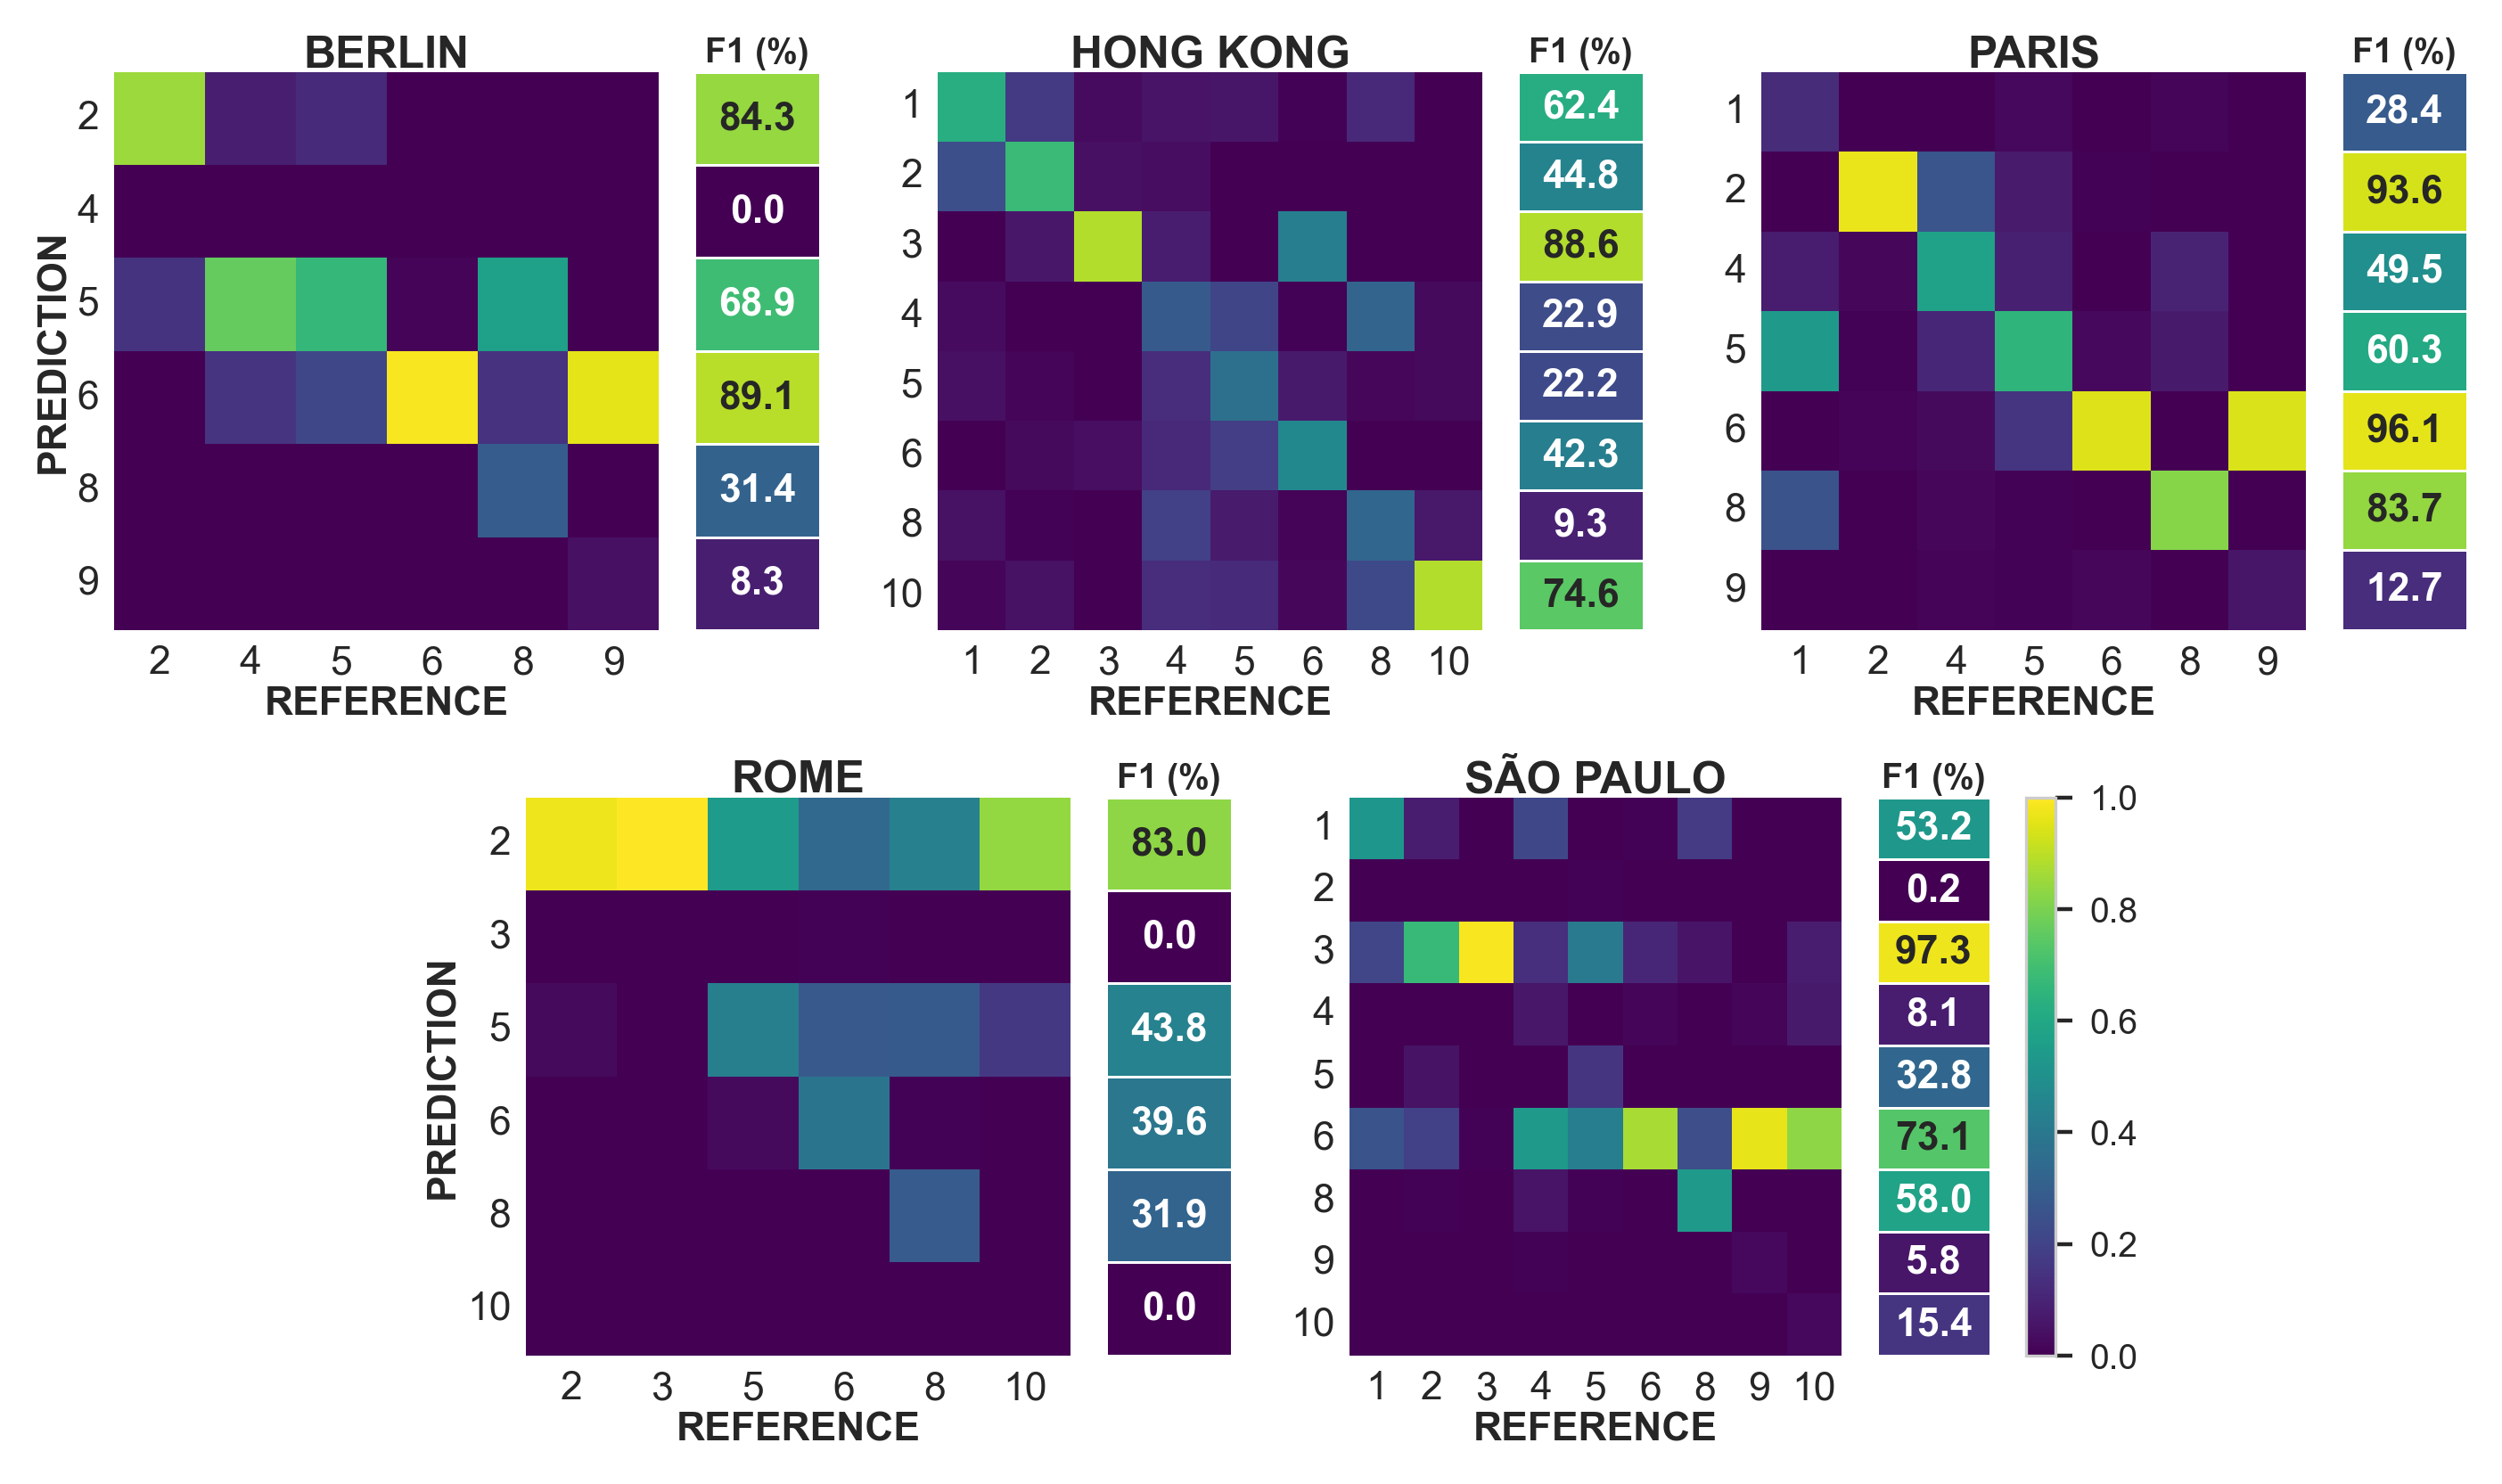

In [8]:
FIG_WIDTH = 7.5   
FIG_HEIGHT = 4 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'axes.linewidth': 0.6,
})

sites_data = {
    'BERLIN':    (berlin_s1, berlin_s1_cm),
    'HONG KONG': (hongkong_s1, hongkong_s1_cm),
    'PARIS':     (paris_s1, paris_s1_cm),
    'ROME':      (rome_s1, rome_s1_cm),
    'SÃO PAULO': (saopaulo_s1, saopaulo_s1_cm)
}

def plot_site_composite(ax, df_results, cm_raw, site_name, show_ylabel=True, show_cbar=False):
    agg = df_results.groupby("Strategy").mean(numeric_only=True)
    if 'wF1' in agg.columns:
        best_strat = agg["wF1"].idxmax()
    else:
        best_strat = agg.index[0]
        
    stats_row = agg.loc[best_strat]

    labels_found = []
    for col in stats_row.index:
        if str(col).startswith("F1_Class_") and not pd.isna(stats_row[col]):
            try:
                class_id = int(str(col).split("_")[-1])
                labels_found.append(class_id)
            except ValueError:
                continue
    ordered_labels = sorted(labels_found)

    f1_values = []
    for label in ordered_labels:
        col_name = f"F1_Class_{label}"
        f1_values.append(stats_row[col_name])
    f1_matrix = np.array(f1_values).reshape(-1, 1)

    row_sums = cm_raw.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1 
    norm_cm = cm_raw.astype('float') / row_sums
    
    if norm_cm.shape[0] == len(ordered_labels):
        cm_subset = norm_cm
    else:
        indices = [label - 1 for label in ordered_labels]
        indices = [i for i in indices if i < norm_cm.shape[0]]
        cm_subset = norm_cm[np.ix_(indices, indices)]

    plot_matrix = cm_subset.T

    hm = sns.heatmap(plot_matrix, 
                annot=False, 
                cmap='viridis', 
                vmin=0.0, vmax=1.0, 
                xticklabels=ordered_labels, 
                yticklabels=ordered_labels,
                cbar=False, 
                ax=ax)
    
    ax.set_title(site_name, fontweight='bold', fontsize=9, pad=1)
    ax.set_xlabel('REFERENCE', fontsize=8, fontweight='bold', labelpad=1)
    
    if show_ylabel:
        ax.set_ylabel('PREDICTION', fontsize=8, fontweight='bold', labelpad=1)
    else:
        ax.set_ylabel('') 
        
    ax.tick_params(axis='both', which='major', labelsize=8, rotation=0, pad=1, length=2)

    divider = make_axes_locatable(ax)
    
    f1_ax = divider.append_axes("right", size="23%", pad=0.1)
    
    sns.heatmap(f1_matrix, 
                annot=True, 
                fmt='.1f',
                cmap='viridis', 
                cbar=False,    
                xticklabels=[],
                yticklabels=[], 
                ax=f1_ax,
                vmin=0, vmax=100,
                annot_kws={'size': 8, 'weight': 'bold'}, 
                linewidths=0.5,
                linecolor='white')
    
    f1_ax.set_title("F1 (%)", fontsize=7, fontweight='bold', pad=2)

    if show_cbar:
        cax = divider.append_axes("right", size="6%", pad=0.1)
        cbar = plt.colorbar(hm.get_children()[0], cax=cax)
        cbar.ax.tick_params(labelsize=7)


fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=400)

gs = fig.add_gridspec(2, 6, wspace=0.4, hspace=0.3) 

axes = []
axes.append(fig.add_subplot(gs[0, 0:2]))
axes.append(fig.add_subplot(gs[0, 2:4]))
axes.append(fig.add_subplot(gs[0, 4:6]))
axes.append(fig.add_subplot(gs[1, 1:3]))
axes.append(fig.add_subplot(gs[1, 3:5]))

site_names = list(sites_data.keys())

for i, ax in enumerate(axes):
    if i < len(site_names):
        name = site_names[i]
        df, cm = sites_data[name]
        
        show_y = (i == 0 or i == 3)
        
        is_last = (i == 4)
        
        plot_site_composite(ax, df, cm, name, show_ylabel=show_y, show_cbar=is_last)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.06, right=0.94)
plt.savefig(r'figures\figure6.jpg', dpi=1000, bbox_inches='tight')
plt.show()

# Morphometric subsets

In [14]:
def preprocess(df):
    df.columns = ['Importance']
    
    is_building = df.index.str.startswith(('b_', 'building_', 'mean_ib_dist_'))
    
    is_cell = df.index.str.startswith(('t_', 'granularity_'))

    df['Building'] = np.where(is_building, 1, 0)
    df['ETC'] = np.where(is_cell, 1, 0)
    
    df['Street'] = np.where(~(is_building | is_cell), 1, 0)
    df['Other'] = 0

    return df

def create_alias(feature_name):
    clean_name = re.sub(r'^(b_|t_|s_)', '', feature_name)
    
    match = re.search(r'(_weighted|_25|_50|_75)', clean_name)
    
    if match:
        split_index = match.start()
        base_part = clean_name[:split_index]
        suffix_part = clean_name[split_index:]
    else:
        base_part = clean_name
        suffix_part = ""
    
    if base_part:
        formatted_base = "".join(word.capitalize() for word in base_part.split('_'))
    else:
        formatted_base = ""
        
    formatted_base = re.sub(r'([a-zA-Z])(\d+)', r'\1_r\2', formatted_base)
    
    full_alias = formatted_base + suffix_part

    full_alias = full_alias.replace('Compactness_weighted_axis', 'CompactnessWeightedAxis')
    
    full_alias = full_alias.replace('MeanIbDist', 'MeanInterBuildDist')
    
    full_alias = full_alias.replace('MeanNd', 'MeanNodeDegree')

    full_alias = full_alias.replace('NeighboursDistOrder_r2', 'NeighbourDistance_r2steps')
    full_alias = full_alias.replace('NeighboursDistOrder_r3', 'NeighbourDistance_r3steps')

    full_alias = full_alias.replace('NodeDensity_weighted', 'NodeDensity_r400m')

    full_alias = re.sub(r'_weighted_(\d+)m', r'_w\1m', full_alias)
        
    full_alias = re.sub(r'_weighted_order(\d+)', r'_w\1steps', full_alias)
        
    return full_alias

In [15]:
berlin_metrics = pd.read_csv(r"results\berlin_S1_top_features_non_weighted_model.csv", index_col=0)
berlin_metrics_weighted = pd.read_csv(r"results\berlin_S1_top_features_weighted_model.csv", index_col=0)

hongkong_metrics = pd.read_csv(r"results\hongkong_S1_top_features_non_weighted_model.csv", index_col=0)
hongkong_metrics_weighted = pd.read_csv(r"results\hongkong_S1_top_features_weighted_model.csv", index_col=0)

rome_metrics = pd.read_csv(r"results\rome_S1_top_features_non_weighted_model.csv", index_col=0)
rome_metrics_weighted = pd.read_csv(r"results\rome_S1_top_features_weighted_model.csv", index_col=0)

paris_metrics = pd.read_csv(r"results\paris_S1_top_features_non_weighted_model.csv", index_col=0)
saopaulo_metrics_weighted = pd.read_csv(r"results\saopaulo_S1_top_features_weighted_model.csv", index_col=0)

## Preprocess Berlin

In [16]:
berlin_metrics = preprocess(berlin_metrics)
berlin_metrics['Alias'] = berlin_metrics.index.to_series().apply(create_alias)

berlin_metrics_weighted = preprocess(berlin_metrics_weighted)
berlin_metrics_weighted['Alias'] = berlin_metrics_weighted.index.to_series().apply(create_alias)

In [17]:
berlin_metrics

Importance  Building  ETC  Street  \
b_perimeter_wall_length_weighted_200m_50   10.686251         1    0       0   
b_perimeter_wall_length_weighted_200m_25    8.124325         1    0       0   
b_perimeter_wall_length_weighted_200m_75    7.275870         1    0       0   
b_perimeter_wall_length_weighted_100m_25    6.010430         1    0       0   
b_perimeter_wall_length_weighted_100m_75    4.542760         1    0       0   
b_perimeter_wall_length_50                  3.814574         1    0       0   
b_circular_compactness_weighted_200m_75     3.780366         1    0       0   
b_perimeter_wall_length_weighted_100m_50    3.285912         1    0       0   
b_perimeter_wall_length_75                  3.160151         1    0       0   
t_coverage_area_ratio_weighted_order3_75    2.844832         0    1       0   
t_coverage_area_ratio_75                    2.349426         0    1       0   
b_shape_index_weighted_200m_75              2.199859         1    0       0   
t_coverage_area_ratio_50                    2.045615         0    1       0   
t_coverage_area_ratio_weighted_order3_50    2.003318         0    1       0   
b_facade_ratio_weighted_200m_50             1.483349         1    0       0   
mean_nd_75                                  1.292259         0    0       1   
mean_nd_50                                  1.221583         0    0       1   
t_coverage_area_ratio_25                    1.215823         0    1       0   
b_shape_index_weighted_200m_50              1.165526         1    0       0   
b_shape_index_weighted_200m_25              1.165401         1    0       0   

                                          Other                         Alias  
b_perimeter_wall_length_weighted_200m_50      0  PerimeterWallLength_w200m_50  
b_perimeter_wall_length_weighted_200m_25      0  PerimeterWallLength_w200m_25  
b_perimeter_wall_length_weighted_200m_75      0  PerimeterWallLength_w200m_75  
b_perimeter_wall_length_weighted_100m_25      0  PerimeterWallLength_w100m_25  
b_perimeter_wall_length_weighted_100m_75      0  PerimeterWallLength_w100m_75  
b_perimeter_wall_length_50                    0        PerimeterWallLength_50  
b_circular_compactness_weighted_200m_75       0  CircularCompactness_w200m_75  
b_perimeter_wall_length_weighted_100m_50      0  PerimeterWallLength_w100m_50  
b_perimeter_wall_length_75                    0        PerimeterWallLength_75  
t_coverage_area_ratio_weighted_order3_75      0  CoverageAreaRatio_w3steps_75  
t_coverage_area_ratio_75                      0          CoverageAreaRatio_75  
b_shape_index_weighted_200m_75                0           ShapeIndex_w200m_75  
t_coverage_area_ratio_50                      0          CoverageAreaRatio_50  
t_coverage_area_ratio_weighted_order3_50      0  CoverageAreaRatio_w3steps_50  
b_facade_ratio_weighted_200m_50               0          FacadeRatio_w200m_50  
mean_nd_75                                    0             MeanNodeDegree_75  
mean_nd_50                                    0             MeanNodeDegree_50  
t_coverage_area_ratio_25                      0          CoverageAreaRatio_25  
b_shape_index_weighted_200m_50                0           ShapeIndex_w200m_50  
b_shape_index_weighted_200m_25                0           ShapeIndex_w200m_25

In [18]:
berlin_metrics_weighted

Importance  Building  ETC  \
b_perimeter_wall_length_weighted_200m_50           1.988264         1    0   
b_fractal_dimension_weighted_200m_25               1.633080         1    0   
b_equivalent_rectangular_index_weighted_200m_75    1.550276         1    0   
b_square_compactness_weighted_200m_50              1.508193         1    0   
t_coverage_area_ratio_25                           1.416801         0    1   
t_coverage_area_ratio_weighted_order3_75           1.318275         0    1   
b_elongation_weighted_200m_50                      1.291546         1    0   
t_coverage_area_ratio_weighted_order3_25           1.289134         0    1   
b_facade_ratio_weighted_200m_50                    1.251557         1    0   
b_facade_ratio_weighted_200m_25                    1.226765         1    0   
b_perimeter_wall_length_weighted_100m_25           1.220029         1    0   
building_adjacency_75                              1.177453         1    0   
b_perimeter_wall_length_weighted_200m_25           1.138054         1    0   
b_compactness_weighted_axis_weighted_100m_50       1.118097         1    0   
openness_25                                        1.113537         0    0   
b_square_compactness_weighted_200m_25              1.073232         1    0   
b_shape_index_weighted_200m_25                     1.062982         1    0   
openness_50                                        1.053658         0    0   
b_perimeter_wall_length_50                         1.044755         1    0   
b_axis_length_weighted_100m_75                     1.034565         1    0   

                                                 Street  Other  \
b_perimeter_wall_length_weighted_200m_50              0      0   
b_fractal_dimension_weighted_200m_25                  0      0   
b_equivalent_rectangular_index_weighted_200m_75       0      0   
b_square_compactness_weighted_200m_50                 0      0   
t_coverage_area_ratio_25                              0      0   
t_coverage_area_ratio_weighted_order3_75              0      0   
b_elongation_weighted_200m_50                         0      0   
t_coverage_area_ratio_weighted_order3_25              0      0   
b_facade_ratio_weighted_200m_50                       0      0   
b_facade_ratio_weighted_200m_25                       0      0   
b_perimeter_wall_length_weighted_100m_25              0      0   
building_adjacency_75                                 0      0   
b_perimeter_wall_length_weighted_200m_25              0      0   
b_compactness_weighted_axis_weighted_100m_50          0      0   
openness_25                                           1      0   
b_square_compactness_weighted_200m_25                 0      0   
b_shape_index_weighted_200m_25                        0      0   
openness_50                                           1      0   
b_perimeter_wall_length_50                            0      0   
b_axis_length_weighted_100m_75                        0      0   

                                                                               Alias  
b_perimeter_wall_length_weighted_200m_50                PerimeterWallLength_w200m_50  
b_fractal_dimension_weighted_200m_25                       FractalDimension_w200m_25  
b_equivalent_rectangular_index_weighted_200m_75  EquivalentRectangularIndex_w200m_75  
b_square_compactness_weighted_200m_50                     SquareCompactness_w200m_50  
t_coverage_area_ratio_25                                        CoverageAreaRatio_25  
t_coverage_area_ratio_weighted_order3_75                CoverageAreaRatio_w3steps_75  
b_elongation_weighted_200m_50                                    Elongation_w200m_50  
t_coverage_area_ratio_weighted_order3_25                CoverageAreaRatio_w3steps_25  
b_facade_ratio_weighted_200m_50                                 FacadeRatio_w200m_50  
b_facade_ratio_weighted_200m_25                                 FacadeRatio_w200m_25  
b_perimeter_wall_length_weighted_100m_25                PerimeterW

## Preprocess Hong Kong

In [19]:
hongkong_metrics = preprocess(hongkong_metrics)
hongkong_metrics['Alias'] = hongkong_metrics.index.to_series().apply(create_alias)

hongkong_metrics_weighted = preprocess(hongkong_metrics_weighted)
hongkong_metrics_weighted['Alias'] = hongkong_metrics_weighted.index.to_series().apply(create_alias)

In [20]:
hongkong_metrics

Importance  Building  ETC  Street  \
b_perimeter_wall_length_weighted_200m_50    9.656045         1    0       0   
b_perimeter_wall_length_75                  7.786241         1    0       0   
b_perimeter_wall_length_weighted_200m_25    7.757338         1    0       0   
b_perimeter_wall_length_weighted_200m_75    7.179556         1    0       0   
b_facade_ratio_weighted_200m_25             5.917352         1    0       0   
openness_25                                 3.952999         0    0       1   
b_facade_ratio_weighted_200m_50             3.518907         1    0       0   
b_perimeter_wall_length_weighted_100m_50    3.011873         1    0       0   
meshedness400_50                            2.947905         0    0       1   
b_perimeter_wall_length_weighted_100m_75    2.942792         1    0       0   
t_rectangularity_weighted_order3_75         2.371372         0    1       0   
b_axis_length_50                            2.338704         1    0       0   
cyclomatic400_50                            2.154143         0    0       1   
b_rectangularity_weighted_200m_25           1.846230         1    0       0   
b_neighbours_200m_25                        1.802365         1    0       0   
b_compactness_weighted_axis_75              1.762581         1    0       0   
edge_node_ratio400_75                       1.662682         0    0       1   
mean_ib_dist_50                             1.576723         1    0       0   
openness_50                                 1.520329         0    0       1   
b_neighbours_200m_50                        1.512400         1    0       0   

                                          Other                         Alias  
b_perimeter_wall_length_weighted_200m_50      0  PerimeterWallLength_w200m_50  
b_perimeter_wall_length_75                    0        PerimeterWallLength_75  
b_perimeter_wall_length_weighted_200m_25      0  PerimeterWallLength_w200m_25  
b_perimeter_wall_length_weighted_200m_75      0  PerimeterWallLength_w200m_75  
b_facade_ratio_weighted_200m_25               0          FacadeRatio_w200m_25  
openness_25                                   0                   Openness_25  
b_facade_ratio_weighted_200m_50               0          FacadeRatio_w200m_50  
b_perimeter_wall_length_weighted_100m_50      0  PerimeterWallLength_w100m_50  
meshedness400_50                              0            Meshedness_r400_50  
b_perimeter_wall_length_weighted_100m_75      0  PerimeterWallLength_w100m_75  
t_rectangularity_weighted_order3_75           0     Rectangularity_w3steps_75  
b_axis_length_50                              0                 AxisLength_50  
cyclomatic400_50                              0            Cyclomatic_r400_50  
b_rectangularity_weighted_200m_25             0       Rectangularity_w200m_25  
b_neighbours_200m_25                          0           Neighbours_r200m_25  
b_compactness_weighted_axis_75                0    CompactnessWeightedAxis_75  
edge_node_ratio400_75                         0         EdgeNodeRatio_r400_75  
mean_ib_dist_50                               0         MeanInterBuildDist_50  
openness_50                                   0                   Openness_50  
b_neighbours_200m_50                          0           Neighbours_r200m_50

In [21]:
hongkong_metrics_weighted

Importance  Building  ETC  \
granularity_75                                     1.834672         0    1   
t_axis_length_weighted_order3_50                   1.667528         0    1   
b_compactness_weighted_axis_weighted_100m_75       1.630669         1    0   
b_equivalent_rectangular_index_weighted_200m_75    1.533526         1    0   
t_coverage_area_ratio_weighted_order3_75           1.501567         0    1   
width_50                                           1.434735         0    0   
t_neighbours_dist_order2_50                        1.406032         0    1   
cyclomatic400_50                                   1.344355         0    0   
b_perimeter_wall_length_weighted_100m_75           1.302986         1    0   
t_fractal_dimension_50                             1.200599         0    1   
t_coverage_area_ratio_25                           1.178280         0    1   
b_neighbours_dist_100m_25                          1.165067         1    0   
b_shape_index_25                                   1.134570         1    0   
t_convexity_weighted_order3_25                     1.120026         0    1   
t_axis_length_75                                   1.098831         0    1   
b_fractal_dimension_weighted_200m_50               1.078476         1    0   
b_facade_ratio_weighted_200m_50                    1.057759         1    0   
b_elongation_75                                    1.037651         1    0   
node_density_50                                    0.994384         0    0   
t_neighbours_dist_order3_50                        0.993280         0    1   

                                                 Street  Other  \
granularity_75                                        0      0   
t_axis_length_weighted_order3_50                      0      0   
b_compactness_weighted_axis_weighted_100m_75          0      0   
b_equivalent_rectangular_index_weighted_200m_75       0      0   
t_coverage_area_ratio_weighted_order3_75              0      0   
width_50                                              1      0   
t_neighbours_dist_order2_50                           0      0   
cyclomatic400_50                                      1      0   
b_perimeter_wall_length_weighted_100m_75              0      0   
t_fractal_dimension_50                                0      0   
t_coverage_area_ratio_25                              0      0   
b_neighbours_dist_100m_25                             0      0   
b_shape_index_25                                      0      0   
t_convexity_weighted_order3_25                        0      0   
t_axis_length_75                                      0      0   
b_fractal_dimension_weighted_200m_50                  0      0   
b_facade_ratio_weighted_200m_50                       0      0   
b_elongation_75                                       0      0   
node_density_50                                       1      0   
t_neighbours_dist_order3_50                           0      0   

                                                                               Alias  
granularity_75                                                        Granularity_75  
t_axis_length_weighted_order3_50                               AxisLength_w3steps_50  
b_compactness_weighted_axis_weighted_100m_75        CompactnessWeightedAxis_w100m_75  
b_equivalent_rectangular_index_weighted_200m_75  EquivalentRectangularIndex_w200m_75  
t_coverage_area_ratio_weighted_order3_75                CoverageAreaRatio_w3steps_75  
width_50                                                                    Width_50  
t_neighbours_dist_order2_50                             NeighbourDistance_r2steps_50  
cyclomatic400_50                                                  Cyclomatic_r400_50  
b_perimeter_wall_length_weighted_100m_75                PerimeterWallLength_w100m_75  
t_fractal_dimension_50                                           FractalDimension_50  
t_coverage_area_ratio_25                                        Co

## Preprocess Rome

In [22]:
rome_metrics = preprocess(rome_metrics)
rome_metrics['Alias'] = rome_metrics.index.to_series().apply(create_alias)

rome_metrics_weighted = preprocess(rome_metrics_weighted)
rome_metrics_weighted['Alias'] = rome_metrics_weighted.index.to_series().apply(create_alias)

In [23]:
rome_metrics

Importance  Building  ETC  Street  \
t_coverage_area_ratio_weighted_order3_75   11.297697         0    1       0   
t_coverage_area_ratio_75                    8.785136         0    1       0   
b_facade_ratio_weighted_200m_25             8.643716         1    0       0   
t_coverage_area_ratio_50                    7.820165         0    1       0   
s_linearity_50                              7.453696         0    0       1   
b_facade_ratio_weighted_200m_50             4.552302         1    0       0   
mean_ib_dist_25                             4.001119         1    0       0   
b_facade_ratio_weighted_200m_75             2.446336         1    0       0   
openness_25                                 2.103840         0    0       1   
openness_50                                 2.038398         0    0       1   
s_linearity_25                              2.000750         0    0       1   
node_density_weighted_25                    1.985312         0    0       1   
b_facade_ratio_weighted_100m_50             1.696868         1    0       0   
mean_ib_dist_50                             1.685051         1    0       0   
b_convexity_weighted_200m_75                1.400032         1    0       0   
t_coverage_area_ratio_weighted_order3_50    1.183446         0    1       0   
b_fractal_dimension_weighted_100m_25        1.174378         1    0       0   
b_street_alignment_weighted_200m_50         1.157866         1    0       0   
b_convexity_weighted_200m_25                1.124457         1    0       0   
b_rectangularity_weighted_200m_50           1.074162         1    0       0   

                                          Other                         Alias  
t_coverage_area_ratio_weighted_order3_75      0  CoverageAreaRatio_w3steps_75  
t_coverage_area_ratio_75                      0          CoverageAreaRatio_75  
b_facade_ratio_weighted_200m_25               0          FacadeRatio_w200m_25  
t_coverage_area_ratio_50                      0          CoverageAreaRatio_50  
s_linearity_50                                0                  Linearity_50  
b_facade_ratio_weighted_200m_50               0          FacadeRatio_w200m_50  
mean_ib_dist_25                               0         MeanInterBuildDist_25  
b_facade_ratio_weighted_200m_75               0          FacadeRatio_w200m_75  
openness_25                                   0                   Openness_25  
openness_50                                   0                   Openness_50  
s_linearity_25                                0                  Linearity_25  
node_density_weighted_25                      0          NodeDensity_r400m_25  
b_facade_ratio_weighted_100m_50               0          FacadeRatio_w100m_50  
mean_ib_dist_50                               0         MeanInterBuildDist_50  
b_convexity_weighted_200m_75                  0            Convexity_w200m_75  
t_coverage_area_ratio_weighted_order3_50      0  CoverageAreaRatio_w3steps_50  
b_fractal_dimension_weighted_100m_25          0     FractalDimension_w100m_25  
b_street_alignment_weighted_200m_50           0      StreetAlignment_w200m_50  
b_convexity_weighted_200m_25                  0            Convexity_w200m_25  
b_rectangularity_weighted_200m_50             0       Rectangularity_w200m_50

In [24]:
rome_metrics_weighted

Importance  Building  ETC  \
b_facade_ratio_weighted_200m_25                 2.265430         1    0   
b_fractal_dimension_weighted_200m_50            1.993987         1    0   
b_facade_ratio_weighted_100m_75                 1.865157         1    0   
b_compactness_weighted_axis_weighted_200m_25    1.811667         1    0   
t_coverage_area_ratio_weighted_order3_75        1.614416         0    1   
b_square_compactness_weighted_200m_75           1.556041         1    0   
b_facade_ratio_weighted_200m_75                 1.458880         1    0   
b_convexity_weighted_200m_50                    1.340924         1    0   
b_square_compactness_weighted_200m_50           1.307523         1    0   
b_fractal_dimension_weighted_200m_75            1.156764         1    0   
b_axis_length_weighted_200m_75                  1.153893         1    0   
b_circular_compactness_weighted_100m_75         1.134867         1    0   
b_convexity_weighted_200m_25                    1.119990         1    0   
b_axis_length_weighted_100m_25                  1.084624         1    0   
b_fractal_dimension_weighted_100m_25            1.018149         1    0   
b_shape_index_weighted_200m_75                  0.999441         1    0   
b_facade_ratio_weighted_100m_50                 0.978226         1    0   
edge_node_ratio400_25                           0.963205         0    0   
mean_ib_dist_25                                 0.962204         1    0   
b_shape_index_weighted_100m_75                  0.957376         1    0   

                                              Street  Other  \
b_facade_ratio_weighted_200m_25                    0      0   
b_fractal_dimension_weighted_200m_50               0      0   
b_facade_ratio_weighted_100m_75                    0      0   
b_compactness_weighted_axis_weighted_200m_25       0      0   
t_coverage_area_ratio_weighted_order3_75           0      0   
b_square_compactness_weighted_200m_75              0      0   
b_facade_ratio_weighted_200m_75                    0      0   
b_convexity_weighted_200m_50                       0      0   
b_square_compactness_weighted_200m_50              0      0   
b_fractal_dimension_weighted_200m_75               0      0   
b_axis_length_weighted_200m_75                     0      0   
b_circular_compactness_weighted_100m_75            0      0   
b_convexity_weighted_200m_25                       0      0   
b_axis_length_weighted_100m_25                     0      0   
b_fractal_dimension_weighted_100m_25               0      0   
b_shape_index_weighted_200m_75                     0      0   
b_facade_ratio_weighted_100m_50                    0      0   
edge_node_ratio400_25                              1      0   
mean_ib_dist_25                                    0      0   
b_shape_index_weighted_100m_75                     0      0   

                                                                         Alias  
b_facade_ratio_weighted_200m_25                           FacadeRatio_w200m_25  
b_fractal_dimension_weighted_200m_50                 FractalDimension_w200m_50  
b_facade_ratio_weighted_100m_75                           FacadeRatio_w100m_75  
b_compactness_weighted_axis_weighted_200m_25  CompactnessWeightedAxis_w200m_25  
t_coverage_area_ratio_weighted_order3_75          CoverageAreaRatio_w3steps_75  
b_square_compactness_weighted_200m_75               SquareCompactness_w200m_75  
b_facade_ratio_weighted_200m_75                           FacadeRatio_w200m_75  
b_convexity_weighted_200m_50                                Convexity_w200m_50  
b_square_compactness_weighted_200m_50               SquareCompactness_w200m_50  
b_fractal_dimension_weighted_200m_75                 FractalDimension_w200m_75  
b_axis_length_weighted_200m_75                             AxisLength_w200m_75  
b_circular_compactness_weighted_100m_75           CircularCompactness_w100m_75  
b_convexity_weighted_200m_25                                Convexity_w200m_25  
b_axis_lengt

## Preprocess Paris

In [25]:
paris_metrics = preprocess(paris_metrics)
paris_metrics['Alias'] = paris_metrics.index.to_series().apply(create_alias)

In [26]:
paris_metrics

Importance  Building  ETC  \
b_perimeter_wall_length_50                         5.094951         1    0   
b_perimeter_wall_length_weighted_200m_50           3.565189         1    0   
b_equivalent_rectangular_index_weighted_200m_25    2.727989         1    0   
b_axis_length_weighted_200m_25                     2.658985         1    0   
t_coverage_area_ratio_weighted_order3_50           2.567295         0    1   
b_perimeter_wall_length_weighted_100m_25           2.550737         1    0   
b_square_compactness_weighted_200m_75              2.382710         1    0   
b_perimeter_wall_length_weighted_200m_25           2.213561         1    0   
t_coverage_area_ratio_25                           2.211036         0    1   
b_equivalent_rectangular_index_weighted_200m_75    2.210004         1    0   
b_square_compactness_weighted_200m_50              2.197701         1    0   
b_facade_ratio_weighted_200m_50                    2.086732         1    0   
b_compactness_weighted_axis_weighted_100m_25       2.079506         1    0   
b_perimeter_wall_length_weighted_100m_50           1.986017         1    0   
b_perimeter_wall_length_75                         1.725359         1    0   
b_equivalent_rectangular_index_weighted_200m_50    1.701552         1    0   
building_area_75                                   1.620083         1    0   
t_coverage_area_ratio_50                           1.517869         0    1   
b_compactness_weighted_axis_weighted_100m_75       1.505503         1    0   
b_fractal_dimension_weighted_200m_50               1.481330         1    0   

                                                 Street  Other  \
b_perimeter_wall_length_50                            0      0   
b_perimeter_wall_length_weighted_200m_50              0      0   
b_equivalent_rectangular_index_weighted_200m_25       0      0   
b_axis_length_weighted_200m_25                        0      0   
t_coverage_area_ratio_weighted_order3_50              0      0   
b_perimeter_wall_length_weighted_100m_25              0      0   
b_square_compactness_weighted_200m_75                 0      0   
b_perimeter_wall_length_weighted_200m_25              0      0   
t_coverage_area_ratio_25                              0      0   
b_equivalent_rectangular_index_weighted_200m_75       0      0   
b_square_compactness_weighted_200m_50                 0      0   
b_facade_ratio_weighted_200m_50                       0      0   
b_compactness_weighted_axis_weighted_100m_25          0      0   
b_perimeter_wall_length_weighted_100m_50              0      0   
b_perimeter_wall_length_75                            0      0   
b_equivalent_rectangular_index_weighted_200m_50       0      0   
building_area_75                                      0      0   
t_coverage_area_ratio_50                              0      0   
b_compactness_weighted_axis_weighted_100m_75          0      0   
b_fractal_dimension_weighted_200m_50                  0      0   

                                                                               Alias  
b_perimeter_wall_length_50                                    PerimeterWallLength_50  
b_perimeter_wall_length_weighted_200m_50                PerimeterWallLength_w200m_50  
b_equivalent_rectangular_index_weighted_200m_25  EquivalentRectangularIndex_w200m_25  
b_axis_length_weighted_200m_25                                   AxisLength_w200m_25  
t_coverage_area_ratio_weighted_order3_50                CoverageAreaRatio_w3steps_50  
b_perimeter_wall_length_weighted_100m_25                PerimeterWallLength_w100m_25  
b_square_compactness_weighted_200m_75                     SquareCompactness_w200m_75  
b_perimeter_wall_length_weighted_200m_25                PerimeterWallLength_w200m_25  
t_coverage_area_ratio_25                                        CoverageAreaRatio_25  
b_equivalent_rectangular_index_weighted_200m_75  EquivalentRectangularIndex_w200m_75  
b_square_compactness_weighted_200m_50                     SquareCo

## Preprocess Sao Paulo

In [27]:
saopaulo_metrics_weighted = preprocess(saopaulo_metrics_weighted)
saopaulo_metrics_weighted['Alias'] = saopaulo_metrics_weighted.index.to_series().apply(create_alias)

In [28]:
saopaulo_metrics_weighted

Importance  Building  ETC  Street  \
mean_nd_25                                  2.416521         0    0       1   
b_neighbours_200m_50                        2.045690         1    0       0   
mean_nd_75                                  2.032164         0    0       1   
mean_nd_50                                  1.974189         0    0       1   
b_facade_ratio_weighted_200m_75             1.892320         1    0       0   
b_axis_length_weighted_200m_25              1.889856         1    0       0   
mean_ib_dist_75                             1.809330         1    0       0   
b_facade_ratio_weighted_200m_50             1.732854         1    0       0   
t_coverage_area_ratio_weighted_order3_50    1.657464         0    1       0   
b_facade_ratio_weighted_200m_25             1.572348         1    0       0   
b_axis_length_weighted_200m_50              1.517553         1    0       0   
mean_ib_dist_50                             1.320700         1    0       0   
b_neighbours_200m_75                        1.218277         1    0       0   
t_coverage_area_ratio_weighted_order3_75    1.166870         0    1       0   
openness_75                                 1.163654         0    0       1   
b_neighbours_200m_25                        1.054287         1    0       0   
t_coverage_area_ratio_weighted_order3_25    1.024633         0    1       0   
b_fractal_dimension_weighted_200m_75        0.956211         1    0       0   
building_adjacency_25                       0.949173         1    0       0   
cyclomatic_50                               0.946383         0    0       1   

                                          Other                         Alias  
mean_nd_25                                    0             MeanNodeDegree_25  
b_neighbours_200m_50                          0           Neighbours_r200m_50  
mean_nd_75                                    0             MeanNodeDegree_75  
mean_nd_50                                    0             MeanNodeDegree_50  
b_facade_ratio_weighted_200m_75               0          FacadeRatio_w200m_75  
b_axis_length_weighted_200m_25                0           AxisLength_w200m_25  
mean_ib_dist_75                               0         MeanInterBuildDist_75  
b_facade_ratio_weighted_200m_50               0          FacadeRatio_w200m_50  
t_coverage_area_ratio_weighted_order3_50      0  CoverageAreaRatio_w3steps_50  
b_facade_ratio_weighted_200m_25               0          FacadeRatio_w200m_25  
b_axis_length_weighted_200m_50                0           AxisLength_w200m_50  
mean_ib_dist_50                               0         MeanInterBuildDist_50  
b_neighbours_200m_75                          0           Neighbours_r200m_75  
t_coverage_area_ratio_weighted_order3_75      0  CoverageAreaRatio_w3steps_75  
openness_75                                   0                   Openness_75  
b_neighbours_200m_25                          0           Neighbours_r200m_25  
t_coverage_area_ratio_weighted_order3_25      0  CoverageAreaRatio_w3steps_25  
b_fractal_dimension_weighted_200m_75          0     FractalDimension_w200m_75  
building_adjacency_25                         0          BuildingAdjacency_25  
cyclomatic_50                                 0                 Cyclomatic_50

In [29]:
import pandas as pd
import re
from collections import Counter, defaultdict

site_dfs = {
    'BERLIN': [berlin_metrics, berlin_metrics_weighted],
    'HONG KONG': [hongkong_metrics, hongkong_metrics_weighted],
    'ROME': [rome_metrics, rome_metrics_weighted],
    'PARIS': [paris_metrics], 
    'SÃO PAULO': [saopaulo_metrics_weighted]
}

def get_base_feature_name(raw_name):
    name = str(raw_name)
    
    name = name.replace('_weighted', '')
    
    name = re.sub(r'_\d+m', '', name)
    name = re.sub(r'_order\d+', '', name)

    name = re.sub(r'_\d+$', '', name)
    
    return name

site_features = {}

for site, dfs_list in site_dfs.items():
    unique_base_names = set()
    for df in dfs_list:
        for feature in df.index:
            base_name = get_base_feature_name(feature)
            unique_base_names.add(base_name)
    site_features[site] = unique_base_names

feature_counts = Counter()
for features in site_features.values():
    feature_counts.update(features)

features_by_count = defaultdict(list)
for feature, count in feature_counts.items():
    features_by_count[count].append(feature)

print("-" * 60)
print("FEATURE CONSISTENCY ANALYSIS ACROSS SITES")
print("-" * 60)

for count in [5, 4, 3]:
    feats = sorted(features_by_count[count])
    print(f"\n[ Used in {count} Sites ] - Total: {len(feats)}")
    if feats:
        for f in feats:
            print(f"  • {f}")
    else:
        print("  (None)")

------------------------------------------------------------
FEATURE CONSISTENCY ANALYSIS ACROSS SITES
------------------------------------------------------------

[ Used in 5 Sites ] - Total: 4
  • b_axis_length
  • b_facade_ratio
  • b_fractal_dimension
  • t_coverage_area_ratio

[ Used in 4 Sites ] - Total: 2
  • b_compactness_axis
  • openness

[ Used in 3 Sites ] - Total: 5
  • b_equivalent_rectangular_index
  • b_perimeter_wall_length
  • b_shape_index
  • b_square_compactness
  • mean_ib_dist
------------------------------------------------------------

[ Detailed Breakdown for 4-Site Features ]
  • b_compactness_axis                       Missing in: SÃO PAULO
  • openness                                 Missing in: PARIS


## Get performance metrics

In [30]:
berlin_s1 = pd.read_csv(r"results\berlin_S1_results.csv", index_col=[0, 1])
hongkong_s1 = pd.read_csv(r"results\hongkong_S1_results.csv", index_col=[0, 1])
paris_s1 = pd.read_csv(r"results\paris_S1_results.csv", index_col=[0, 1])
rome_s1 = pd.read_csv(r"results\rome_S1_results.csv", index_col=[0, 1])
saopaulo_s1 = pd.read_csv(r"results\saopaulo_S1_results.csv", index_col=[0, 1])

In [31]:
berlin_max = berlin_s1.groupby('Strategy')[['OA', 'wF1']].max()
berlin_max_oa_non_weighted = berlin_max.loc['non_weighted_model', 'OA']
berlin_max_f1_non_weighted = berlin_max.loc['non_weighted_model', 'wF1']
berlin_max_oa_weighted = berlin_max.loc['weighted_model', 'OA']
berlin_max_f1_weighted = berlin_max.loc['weighted_model', 'wF1']

hongkong_max = hongkong_s1.groupby('Strategy')[['OA', 'wF1']].max()
hongkong_max_oa_non_weighted = hongkong_max.loc['non_weighted_model', 'OA']
hongkong_max_f1_non_weighted = hongkong_max.loc['non_weighted_model', 'wF1']
hongkong_max_oa_weighted = hongkong_max.loc['weighted_model', 'OA']
hongkong_max_f1_weighted = hongkong_max.loc['weighted_model', 'wF1']

paris_max = paris_s1.groupby('Strategy')[['OA', 'wF1']].max()
paris_max_oa_non_weighted = paris_max.loc['non_weighted_model', 'OA']
paris_max_f1_non_weighted = paris_max.loc['non_weighted_model', 'wF1']

rome_max = rome_s1.groupby('Strategy')[['OA', 'wF1']].max()
rome_max_oa_non_weighted = rome_max.loc['non_weighted_model', 'OA']
rome_max_f1_non_weighted = rome_max.loc['non_weighted_model', 'wF1']
rome_max_oa_weighted = rome_max.loc['weighted_model', 'OA']
rome_max_f1_weighted = rome_max.loc['weighted_model', 'wF1']

saopaulo_max = saopaulo_s1.groupby('Strategy')[['OA', 'wF1']].max()
saopaulo_max_oa_weighted = saopaulo_max.loc['weighted_model', 'OA']
saopaulo_max_f1_weighted = saopaulo_max.loc['weighted_model', 'wF1']

## Plot

In [34]:
FIG_WIDTH = 7.48
FIG_HEIGHT = 8.5 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.5,
})

COLOR_MAP = {
    'Building': '#cd858b', 
    'Street':   '#66c2a5', 
    'ETC':     '#8da0cb', 
    'Other':    '#d3d3d3' 
}

def get_bar_color(row):
    if row.get('Building', 0) == 1:
        return COLOR_MAP['Building']
    elif row.get('Street', 0) == 1:
        return COLOR_MAP['Street']
    elif row.get('ETC', 0) == 1:
        return COLOR_MAP['ETC']
    else:
        return COLOR_MAP['Other']

def plot_importance(ax, df, title, is_right_column=False):
    df = df.copy()
    
    val_col = None
    if 'Importance' in df.columns: val_col = 'Importance'
    elif '0' in df.columns: val_col = '0'
    elif 0 in df.columns: val_col = 0
    else: val_col = df.columns[0]
        
    df_sorted = df.sort_values(by=val_col, ascending=True)

    bar_colors = df_sorted.apply(get_bar_color, axis=1).tolist()
    
    if 'Alias' in df_sorted.columns:
        y_labels = df_sorted['Alias'].astype(str).values
    else:
        y_labels = df_sorted.index.astype(str).values

    y_pos = range(len(df_sorted))
    values = df_sorted[val_col].values
    
    bars = ax.barh(y_pos, values, 
                   color=bar_colors, edgecolor='black', linewidth=0.5, height=0.7)

    ax.set_title(title, fontsize=7.5, fontweight='bold', pad=4)
    ax.set_xlabel('Relative Importance (%)', fontsize=6, labelpad=1)
    
    if is_right_column:
        ax.yaxis.tick_right()      
        ax.yaxis.set_label_position("right")
    else:
        ax.yaxis.tick_left()     
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels, fontsize=6)
    
    for tick_label, color in zip(ax.get_yticklabels(), bar_colors):
        tick_label.set_color(color)
        tick_label.set_fontweight('bold')
    
    max_val = values.max() if len(values) > 0 else 10
    limit = max_val * 1.35
    
    if is_right_column:
        ax.set_xlim(limit, 0) 
    else:
        ax.set_xlim(0, limit)
    
    ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, zorder=0)
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', length=0) 
    ax.tick_params(axis='x', labelsize=6, pad=1)
    
plot_structure = [
    [
        {"data": berlin_metrics, "title": f"BERLIN (Non-Weighted model), F1: {round(berlin_max_f1_non_weighted,1)}, OA: {round(berlin_max_oa_non_weighted,1)}"},
        {"data": berlin_metrics_weighted, "title": f"BERLIN (Weighted model), F1: {round(berlin_max_f1_weighted,1)}, OA: {round(berlin_max_oa_weighted,1)}"}
    ],
    [
        {"data": hongkong_metrics, "title": f"HONG KONG (Non-Weighted model), F1: {round(hongkong_max_f1_non_weighted,1)}, OA: {round(hongkong_max_oa_non_weighted,1)}"},
        {"data": hongkong_metrics_weighted, "title": f"HONG KONG (Weighted model), F1: {round(hongkong_max_f1_weighted,1)}, OA: {round(hongkong_max_oa_weighted,1)}"}
    ],
    [
        {"data": rome_metrics, "title": f"ROME (Non-Weighted model), F1: {round(rome_max_f1_non_weighted,1)}, OA: {round(rome_max_oa_non_weighted,1)}"},
        {"data": rome_metrics_weighted, "title": f"ROME (Weighted model), F1: {round(rome_max_f1_weighted,1)}, OA: {round(rome_max_oa_weighted,1)}"}
    ],
    [
        {"data": paris_metrics, "title": f"PARIS (Non-Weighted model), F1: {round(paris_max_f1_non_weighted,1)}, OA: {round(paris_max_oa_non_weighted,1)}"},
        {"data": saopaulo_metrics_weighted, "title": f"SÃO PAULO (Weighted model), F1: {round(saopaulo_max_f1_weighted,1)}, OA: {round(saopaulo_max_oa_weighted,1)}"}
    ]
]

fig, axes = plt.subplots(4, 2, figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=400)

plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.055, wspace=0.05, hspace=0.30)

for row_idx, row_data in enumerate(plot_structure):
    for col_idx, plot_cfg in enumerate(row_data):
        ax = axes[row_idx, col_idx]
        
        is_right = (col_idx == 1)
        
        plot_importance(ax, plot_cfg["data"], plot_cfg["title"], is_right_column=is_right)

legend_labels = [
    ("Building-based", COLOR_MAP['Building']),
    ("ETC-based", COLOR_MAP['ETC']),
    ("Street-based", COLOR_MAP['Street'])
]

handles = [mpatches.Patch(facecolor=c, edgecolor='black', linewidth=0.5, label=l) 
           for l, c in legend_labels]

fig.legend(handles=handles, 
           loc='lower center', 
           bbox_to_anchor=(0.5, 0), 
           ncol=3, 
           fontsize=7, 
           frameon=False)
plt.savefig(r'figures\SM_figure_1.png', dpi=600, bbox_inches='tight')
plt.show()

# Scheme comparison

In [12]:
berlin_s1_agg = pd.read_csv(r"results\berlin_S1_aggregated_results.csv", index_col=0)
berlin_s2 = pd.read_csv(r"results\berlin_S2_results.csv", index_col=0)
berlin_s3 = pd.read_csv(r"results\berlin_S3_results.csv", index_col=[0,1,2])
berlin_s4 = pd.read_csv(r"results\berlin_S4_results.csv", index_col=[0])
berlin_s2 = berlin_s2.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})
berlin_s3_temp = berlin_s3.copy()
berlin_s3_temp = berlin_s3_temp.groupby(["Setup", "Strategy"]).mean().round(2)
berlin_s3_temp["wF1+F1U"] = berlin_s3_temp["wF1"] + berlin_s3_temp["F1U"]
berlin_s3_temp = berlin_s3_temp.sort_values("wF1+F1U", ascending=False)
best_setup, best_strategy = berlin_s3_temp["wF1+F1U"].idxmax()
berlin_s3 = berlin_s3.loc[best_setup, best_strategy]
berlin_s4 = berlin_s4.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})

hongkong_s1_agg = pd.read_csv(r"results\hongkong_S1_aggregated_results.csv", index_col=0)
hongkong_s2 = pd.read_csv(r"results\hongkong_S2_results.csv", index_col=0)
hongkong_s3 = pd.read_csv(r"results\hongkong_S3_results.csv", index_col=[0,1,2])
hongkong_s4 = pd.read_csv(r"results\hongkong_S4_results.csv", index_col=[0])
hongkong_s2 = hongkong_s2.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})
hongkong_s3_temp = hongkong_s3.copy()
hongkong_s3_temp = hongkong_s3_temp.groupby(["Setup", "Strategy"]).mean().round(2)
hongkong_s3_temp["wF1+F1U"] = hongkong_s3_temp["wF1"] + hongkong_s3_temp["F1U"]
hongkong_s3_temp = hongkong_s3_temp.sort_values("wF1+F1U", ascending=False)
best_setup, best_strategy = hongkong_s3_temp["wF1+F1U"].idxmax()
hongkong_s3 = hongkong_s3.loc[best_setup, best_strategy]
hongkong_s4 = hongkong_s4.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})

paris_s1_agg = pd.read_csv(r"results\paris_S1_aggregated_results.csv", index_col=0)
paris_s2 = pd.read_csv(r"results\paris_S2_results.csv", index_col=0)
paris_s3 = pd.read_csv(r"results\paris_S3_results.csv", index_col=[0,1,2])
paris_s4 = pd.read_csv(r"results\paris_S4_results.csv", index_col=[0])
paris_s2 = paris_s2.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})
paris_s3_temp = paris_s3.copy()
paris_s3_temp = paris_s3_temp.groupby(["Setup", "Strategy"]).mean().round(2)
paris_s3_temp["wF1+F1U"] = paris_s3_temp["wF1"] + paris_s3_temp["F1U"]
paris_s3_temp = paris_s3_temp.sort_values("wF1+F1U", ascending=False)
best_setup, best_strategy = paris_s3_temp["wF1+F1U"].idxmax()
paris_s3 = paris_s3.loc[best_setup, best_strategy]
paris_s4 = paris_s4.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})

rome_s1_agg = pd.read_csv(r"results\rome_S1_aggregated_results.csv", index_col=0)
rome_s2 = pd.read_csv(r"results\rome_S2_results.csv", index_col=0)
rome_s3 = pd.read_csv(r"results\rome_S3_results.csv", index_col=[0,1,2])
rome_s4 = pd.read_csv(r"results\rome_S4_results.csv", index_col=[0])
rome_s2 = rome_s2.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})
rome_s3_temp = rome_s3.copy()
rome_s3_temp = rome_s3_temp.groupby(["Setup", "Strategy"]).mean().round(2)
rome_s3_temp["wF1+F1U"] = rome_s3_temp["wF1"] + rome_s3_temp["F1U"]
rome_s3_temp = rome_s3_temp.sort_values("wF1+F1U", ascending=False)
best_setup, best_strategy = rome_s3_temp["wF1+F1U"].idxmax()
rome_s3 = rome_s3.loc[best_setup, best_strategy]
rome_s4 = rome_s4.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})

saopaulo_s1_agg = pd.read_csv(r"results\saopaulo_S1_aggregated_results.csv", index_col=0)
saopaulo_s2 = pd.read_csv(r"results\saopaulo_S2_results.csv", index_col=0)
saopaulo_s3 = pd.read_csv(r"results\saopaulo_S3_results.csv", index_col=[0,1,2])
saopaulo_s4 = pd.read_csv(r"results\saopaulo_S4_results.csv", index_col=[0])
saopaulo_s2 = saopaulo_s2.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})
saopaulo_s3_temp = saopaulo_s3.copy()
saopaulo_s3_temp = saopaulo_s3_temp.groupby(["Setup", "Strategy"]).mean().round(2)
saopaulo_s3_temp["wF1+F1U"] = saopaulo_s3_temp["wF1"] + saopaulo_s3_temp["F1U"]
saopaulo_s3_temp = saopaulo_s3_temp.sort_values("wF1+F1U", ascending=False)
best_setup, best_strategy = saopaulo_s3_temp["wF1+F1U"].idxmax()
saopaulo_s3 = saopaulo_s3.loc[best_setup, best_strategy]
saopaulo_s4 = saopaulo_s4.rename(columns={'wF1_Urban': 'F1U',
                                     'wF1_Natural':	'F1N'})

In [13]:
FIG_WIDTH = 7.48  
FIG_HEIGHT = 6 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'lines.linewidth': 0.8,
    'axes.linewidth': 0.6,
    'grid.linewidth': 0.5,
})

all_cities_data = {
    'BERLIN': {
        'S1': berlin_s1_agg, 'S2': berlin_s2, 'S3': berlin_s3, 'S4': berlin_s4
    },
    'HONG KONG': {
        'S1': hongkong_s1_agg, 'S2': hongkong_s2, 'S3': hongkong_s3, 'S4': hongkong_s4
    },
    'PARIS': {
        'S1': paris_s1_agg, 'S2': paris_s2, 'S3': paris_s3, 'S4': paris_s4
    },
    'ROME': {
        'S1': rome_s1_agg, 'S2': rome_s2, 'S3': rome_s3, 'S4': rome_s4
    },
    'SÃO PAULO': {
        'S1': saopaulo_s1_agg, 'S2': saopaulo_s2, 'S3': saopaulo_s3, 'S4': saopaulo_s4
    }
}

target_metrics = ['wF1', 'F1U', 'F1N', 'OA']

def plot_city(ax, series_map, city_name, show_ylabel=True, right_axis=False):
    plot_data = []
    for series_name, data_obj in series_map.items():
        if isinstance(data_obj, pd.Series):
            df = data_obj.to_frame().T
        else:
            df = data_obj.copy()

        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        for metric_label in target_metrics:
            col_name = None
            if series_name == 'S1' and metric_label == 'F1U':
                if 'wF1' in df.columns: col_name = 'wF1'
            elif metric_label in df.columns:
                col_name = metric_label
            elif metric_label == 'F1U' and 'wF1_Urban' in df.columns:
                col_name = 'wF1_Urban'
            elif metric_label == 'F1N' and 'wF1_Natural' in df.columns:
                col_name = 'wF1_Natural'
            
            if col_name:
                values = df[col_name].dropna()
                if not values.empty:
                    plot_data.append({
                        'Series': series_name, 'Metric': metric_label,
                        'Mean': values.mean(), 'Min': values.min(), 'Max': values.max()
                    })
    
    df_plot = pd.DataFrame(plot_data)

    sns.barplot(x='Metric', y='Mean', hue='Series', data=df_plot,
                order=target_metrics, hue_order=['S1', 'S2', 'S3', 'S4'],
                palette='Set2', edgecolor='black', linewidth=0.5,
                alpha=1, errorbar=None, legend=False, width=0.90, ax=ax, zorder=3)

    series_order = ['S1', 'S2', 'S3', 'S4']
    WHISKER_COLOR = '#5b5c5d'
    for i, container in enumerate(ax.containers):
        if i >= len(series_order): continue
        series_name = series_order[i]
        for bar in container:
            x_center = bar.get_x() + bar.get_width() / 2
            metric_index = int(round(x_center))
            if 0 <= metric_index < len(target_metrics):
                metric_name = target_metrics[metric_index]
                row = df_plot[(df_plot['Series'] == series_name) & (df_plot['Metric'] == metric_name)]
                if not row.empty:
                    val_mean = float(row['Mean'].values[0])
                    val_min = float(row['Min'].values[0])
                    val_max = float(row['Max'].values[0])
                    
                    if (val_max - val_min) > 1e-9:
                        ax.plot([x_center, x_center], [val_min, val_max], color=WHISKER_COLOR, linewidth=0.8, zorder=10)
                        cap_w = bar.get_width() * 0.2
                        ax.plot([x_center - cap_w, x_center + cap_w], [val_max, val_max], color=WHISKER_COLOR, linewidth=0.8, zorder=10)
                        ax.plot([x_center - cap_w, x_center + cap_w], [val_min, val_min], color=WHISKER_COLOR, linewidth=0.8, zorder=10)

                    ax.text(x_center, val_mean + 0.2, f'{val_mean:.1f}',
                            ha='center', va='bottom', fontsize=6.4, fontweight='bold',
                            color='black', zorder=20, clip_on=False, rotation=0,
                            bbox=dict(facecolor='white', edgecolor='none', pad=0.1, alpha=1))

    ax.set_title(city_name, fontsize=9, fontweight='bold', pad=3)
    
    if right_axis:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    else:
        ax.yaxis.tick_left()
        
    if show_ylabel:
        ax.set_ylabel('Score (%)', fontsize=8, fontweight='bold', labelpad=1)
    else:
        ax.set_ylabel('')
        
    ax.tick_params(axis='both', which='major', labelsize=8, rotation=0, pad=1, length=2)
    new_labels = ['F1', r'F1$_\mathrm{U}$', r'F1$_\mathrm{N}$', 'OA']
    ax.set_xticklabels(new_labels, fontsize=8, fontweight='bold')
    ax.set_xlabel('')
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_yticklabels(np.arange(0, 101, 20), fontsize=8)
    ax.set_ylim(0, 100)
    
    half_width = 0.85 / 1.75
    ax.set_xlim(-half_width, (len(target_metrics) - 1) + half_width)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=1.0, linewidth=0.7, zorder=0)
    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
        spine.set_color('black')

    for y_val in [10,30,50,70, 90]:
        ax.axhline(y=y_val, color='lightgrey', linewidth=0.7, alpha=0.7, zorder=0)

    for spine in ax.spines.values():
        spine.set_linewidth(0.6)
        spine.set_color('black')

fig, axes = plt.subplots(3, 2, figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=400)
axes_flat = axes.flatten()

city_names = list(all_cities_data.keys())

for i, city in enumerate(city_names):
    ax = axes_flat[i]
    
    is_left_col = (i % 2 == 0)
    is_right_col = not is_left_col
    
    plot_city(ax, all_cities_data[city], city, 
              show_ylabel=is_left_col, 
              right_axis=is_right_col)

legend_ax = axes_flat[5]
legend_ax.axis('off')

custom_labels = ["Morphometric-based (S1), 100 m grid", "RS-based (S2)", "Fusion-based, RF (S3)", "Fusion-based, CNN + RF (S4)"]
palette = sns.color_palette("Set2", 4)
handles = [mpatches.Patch(facecolor=palette[i], edgecolor='black', linewidth=0.7, label=custom_labels[i]) for i in range(4)]

legend_ax.legend(handles=handles, 
                 loc='upper left', 
                 bbox_to_anchor=(0, 1), 
                 ncol=1, 
                 fontsize=8, 
                 frameon=False,
                 handleheight=1.5,
                 handlelength=1.5,
                 borderaxespad=0,
                 labelspacing=1.2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.2) 
plt.savefig(r'figures\figure_7.jpg', dpi=1000, bbox_inches='tight')
plt.show()

C:\Users\Markéta\AppData\Local\Temp\ipykernel_28040\2624757766.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=8, fontweight='bold')
C:\Users\Markéta\AppData\Local\Temp\ipykernel_28040\2624757766.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=8, fontweight='bold')
C:\Users\Markéta\AppData\Local\Temp\ipykernel_28040\2624757766.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=8, fontweight='bold')
C:\Users\Markéta\AppData\Local\Temp\ipykernel_28040\2624757766.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

# Confusion matrices comparison

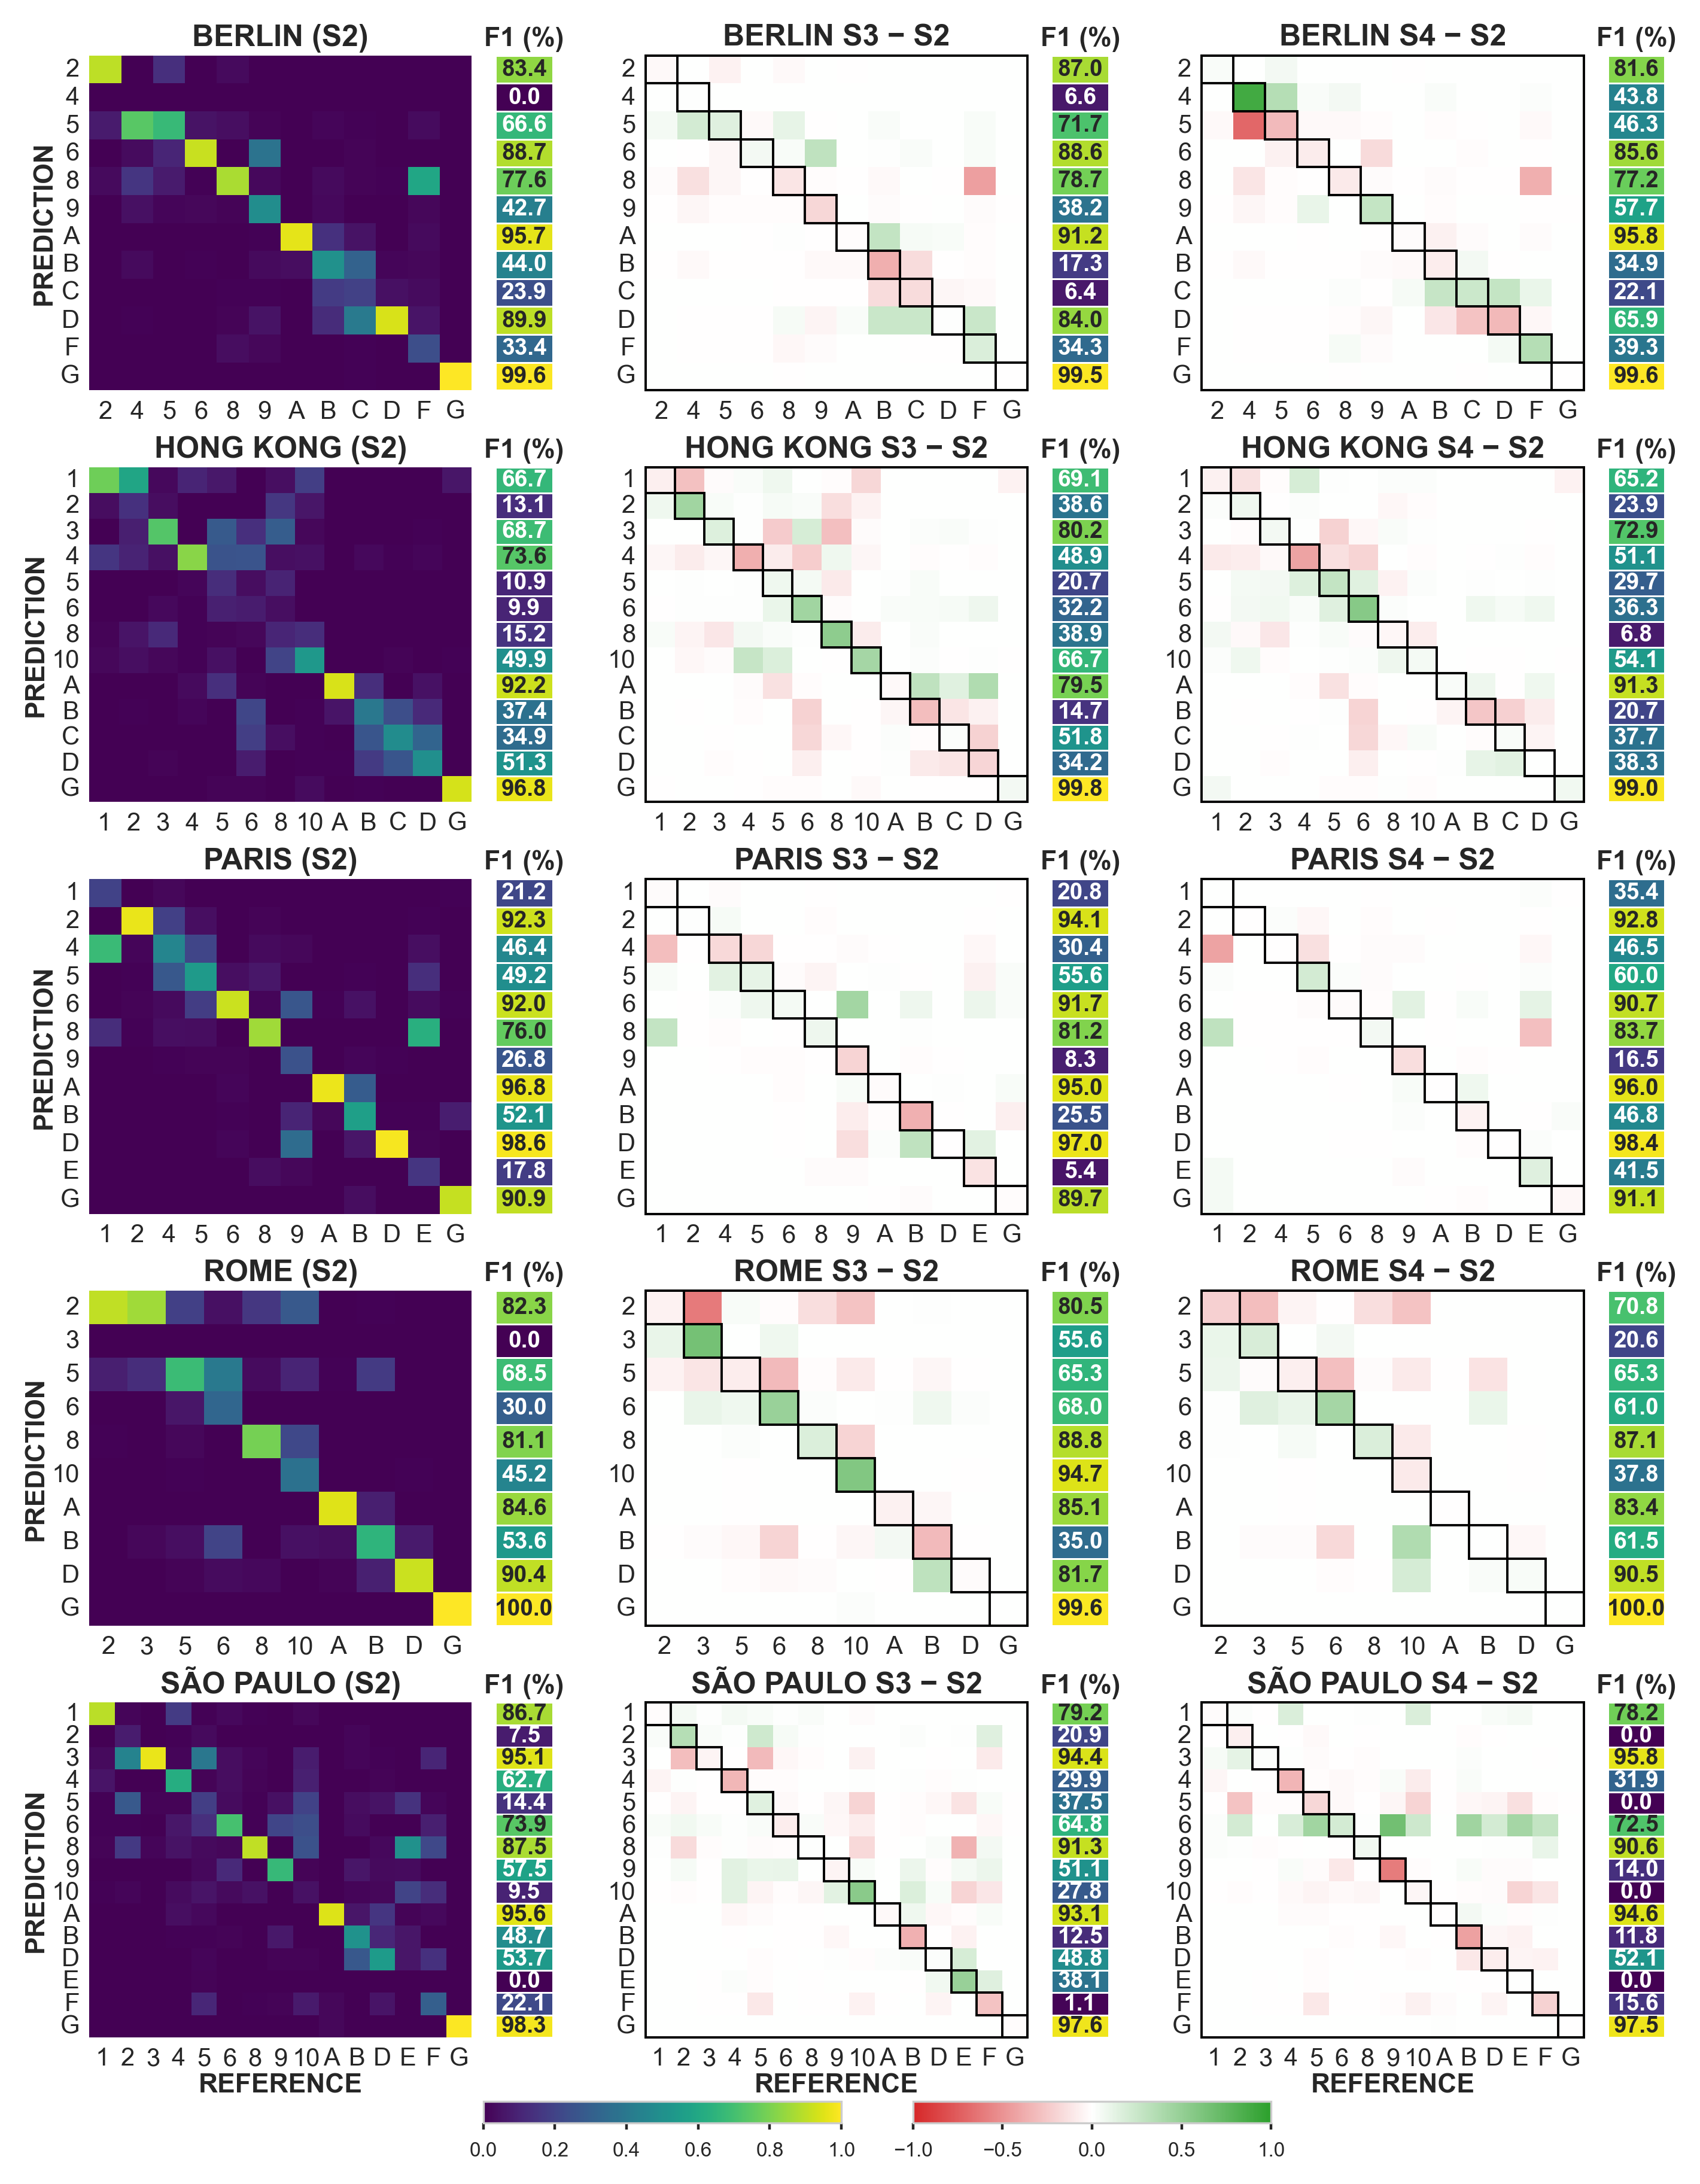

In [11]:
FIG_WIDTH = 7.48  
FIG_HEIGHT = 9

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'axes.linewidth': 0.6,
})

LCZ_MAPPING = {
    11: 'A', 12: 'B', 13: 'C', 14: 'D', 
    15: 'E', 16: 'F', 17: 'G'
}

cities_config = [
    {
        "name": "BERLIN",
        "s2_cm": r'results\berlin_S2_confusion_matrices.pkl',
        "s2_res": r'results\berlin_S2_results.csv',
        "s3_cm": r'results\berlin_S3_summed_cm.npy',
        "s3_res": r'results\berlin_S3_results.csv',
        "s4_cm": r'results\berlin_S4_confusion_matrices.pkl',
        "s4_res": r'results\berlin_S4_results.csv'
    },
    {
        "name": "HONG KONG",
        "s2_cm": r'results\hongkong_S2_confusion_matrices.pkl',
        "s2_res": r'results\hongkong_S2_results.csv',
        "s3_cm": r'results\hongkong_S3_summed_cm.npy',
        "s3_res": r'results\hongkong_S3_results.csv',
        "s4_cm": r'results\hongkong_S4_confusion_matrices.pkl',
        "s4_res": r'results\hongkong_S4_results.csv'
    },
    {
        "name": "PARIS",
        "s2_cm": r'results\paris_S2_confusion_matrices.pkl',
        "s2_res": r'results\paris_S2_results.csv',
        "s3_cm": r'results\paris_S3_summed_cm.npy',
        "s3_res": r'results\paris_S3_results.csv',
        "s4_cm": r'results\paris_S4_confusion_matrices.pkl',
        "s4_res": r'results\paris_S4_results.csv'
    },
    {
        "name": "ROME",
        "s2_cm": r'results\rome_S2_confusion_matrices.pkl',
        "s2_res": r'results\rome_S2_results.csv',
        "s3_cm": r'results\rome_S3_summed_cm.npy',
        "s3_res": r'results\rome_S3_results.csv',
        "s4_cm": r'results\rome_S4_confusion_matrices.pkl',
        "s4_res": r'results\rome_S4_results.csv'
    },
    {
        "name": "SÃO PAULO",
        "s2_cm": r'results\saopaulo_S2_confusion_matrices.pkl',
        "s2_res": r'results\saopaulo_S2_results.csv',
        "s3_cm": r'results\saopaulo_S3_summed_cm.npy',
        "s3_res": r'results\saopaulo_S3_results.csv',
        "s4_cm": r'results\saopaulo_S4_confusion_matrices.pkl',
        "s4_res": r'results\saopaulo_S4_results.csv'
    }
]

def match_matrix_to_labels(matrix, labels):
    if matrix is None: return None
    if matrix.shape[0] == len(labels):
        return matrix
    indices = [l - 1 for l in labels]
    valid_indices = [i for i in indices if i < matrix.shape[0]]
    return matrix[np.ix_(valid_indices, valid_indices)]

def load_s2(cm_path):
    if os.path.exists(cm_path):
        with open(cm_path, 'rb') as f:
            data = pickle.load(f)
        first_key = list(data.keys())[0]
        labels = data[first_key]['labels']
        cm_list = [d['Confusion_Matrix'] for d in data.values()]
        sum_cm = np.sum(cm_list, axis=0)
        row_sums = sum_cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1 
        return (sum_cm / row_sums), labels
    return None, []

def load_s3(cm_path, labels):
    if os.path.exists(cm_path):
        sum_cm = np.load(cm_path)
        sum_cm = match_matrix_to_labels(sum_cm, labels)
        row_sums = sum_cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1 
        return (sum_cm / row_sums)
    return None

def load_s4(cm_path, labels):
    if os.path.exists(cm_path):
        with open(cm_path, 'rb') as f:
            data = pickle.load(f)
        cm_list = [d['Confusion_Matrix'] for d in data.values()]
        sum_cm = np.sum(cm_list, axis=0)
        sum_cm = match_matrix_to_labels(sum_cm, labels)
        row_sums = sum_cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1 
        return (sum_cm / row_sums)
    return None

def get_f1_generic(csv_path, labels):
    f1_vals = []
    if os.path.exists(csv_path) and labels:
        df = pd.read_csv(csv_path, index_col=0)
        for lbl in labels:
            col = f"F1_Class_{lbl}"
            f1_vals.append(df[col].mean() if col in df else 0.0)
    else:
        f1_vals = [0.0] * len(labels)
    return np.array(f1_vals).reshape(-1, 1)

def get_f1_complex(csv_path, labels):
    f1_vals = []
    if os.path.exists(csv_path) and labels:
        df = pd.read_csv(csv_path, index_col=[0,1,2])
        temp = df.groupby(["Setup", "Strategy"]).mean(numeric_only=True)
        if "wF1" in temp.columns and "F1U" in temp.columns:
            temp["score"] = temp["wF1"] + temp["F1U"]
            best_idx = temp["score"].idxmax()
            best_data = df.loc[best_idx]
        else:
            best_data = df
        
        for lbl in labels:
            col = f"F1_Class_{lbl}"
            f1_vals.append(best_data[col].mean() if col in best_data else 0.0)
    else:
        f1_vals = [0.0] * len(labels)
    return np.array(f1_vals).reshape(-1, 1)

def add_border(ax, shape):
    rect = Rectangle((0, 0), shape[1], shape[0], fill=False, edgecolor='black', lw=0.7, clip_on=False)
    ax.add_patch(rect)

def add_diagonal(ax, size):
    for i in range(size):
        rect = Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=0.7)
        ax.add_patch(rect)

fig, axes = plt.subplots(5, 3, figsize=(FIG_WIDTH, FIG_HEIGHT), dpi=400)

plt.subplots_adjust(left=0.06, right=0.94, top=0.96, bottom=0.04, wspace=0.2, hspace=0.23)

colors = ["#d62728", "#ffffff", "#2ca02c"]
div_cmap = LinearSegmentedColormap.from_list("custom_rwg", colors, N=256)

for row_idx, city_cfg in enumerate(cities_config):
    
    norm_s2, labels = load_s2(city_cfg["s2_cm"])
    norm_s3 = load_s3(city_cfg["s3_cm"], labels)
    norm_s4 = load_s4(city_cfg["s4_cm"], labels)
    
    f1_s2 = get_f1_generic(city_cfg["s2_res"], labels)
    f1_s3 = get_f1_complex(city_cfg["s3_res"], labels)
    f1_s4 = get_f1_generic(city_cfg["s4_res"], labels)

    m1 = norm_s2.T if norm_s2 is not None else None
    m2 = (norm_s3 - norm_s2).T if (norm_s3 is not None and norm_s2 is not None) else None
    m3 = (norm_s4 - norm_s2).T if (norm_s4 is not None and norm_s2 is not None) else None
    
    display_labels = [LCZ_MAPPING.get(l, l) for l in labels]
    
    row_plots = [
        {"data": m1, "f1": f1_s2, "title": f"{city_cfg['name']} (S2)", "type": "raw", "cmap": "viridis", "min":0, "max":1},
        {"data": m2, "f1": f1_s3, "title": f"{city_cfg['name']} S3 − S2", "type": "diff", "cmap": None, "min":-1, "max":1},
        {"data": m3, "f1": f1_s4, "title": f"{city_cfg['name']} S4 − S2", "type": "diff", "cmap": None, "min":-1, "max":1}
    ]

    for col_idx, cfg in enumerate(row_plots):
        ax = axes[row_idx, col_idx]
        
        if cfg["data"] is None:
            ax.axis('off')
            continue

        cmap = div_cmap if cfg["type"] == "diff" else cfg["cmap"]
        center = 0 if cfg["type"] == "diff" else None
        
        sns.heatmap(cfg["data"], annot=False, cmap=cmap, center=center,
                    vmin=cfg["min"], vmax=cfg["max"],
                    xticklabels=display_labels, yticklabels=display_labels,
                    cbar=False, ax=ax)
        
        if cfg["type"] == "diff":
            add_border(ax, cfg["data"].shape)
            add_diagonal(ax, len(labels))

        ax.set_title(cfg["title"], fontweight='bold', fontsize=9, pad=3)
        
        if row_idx == 4:
            ax.set_xlabel('REFERENCE', fontsize=8, fontweight='bold', labelpad=1)
        else:
            ax.set_xlabel('')
        
        if col_idx == 0:
            ax.set_ylabel('PREDICTION', fontsize=8, fontweight='bold', labelpad=1)
        else:
            ax.set_ylabel('')
        
        ax.tick_params(axis='y', labelsize=7.5, length=2, rotation=0, pad=1) 
        ax.tick_params(axis='x', labelsize=7.5, length=2, pad=1)

        divider = make_axes_locatable(ax)
        f1_ax = divider.append_axes("right", size="15%", pad=0.1)
        sns.heatmap(cfg["f1"], annot=True, fmt='.1f', cmap='viridis', 
                    cbar=False, xticklabels=[], yticklabels=[], ax=f1_ax,
                    vmin=0, vmax=100, 
                    annot_kws={'size': 7, 'weight': 'bold'},
                    linewidths=0.5, linecolor='white')
        
        f1_ax.set_title("F1 (%)", fontsize=8, fontweight='bold', pad=3)

bar_width = 0.20
gap = 0.04
bar_height = 0.010
bottom_pos = 0.0001

left_x = 0.5 - (gap / 2) - bar_width
cax_vir = fig.add_axes([left_x, bottom_pos, bar_width, bar_height])
sm_vir = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
sm_vir.set_array([])
cb_vir = fig.colorbar(sm_vir, cax=cax_vir, orientation='horizontal')
cb_vir.ax.tick_params(labelsize=6, length=2)

right_x = 0.5 + (gap / 2)
cax_diff = fig.add_axes([right_x, bottom_pos, bar_width, bar_height])
sm_diff = plt.cm.ScalarMappable(cmap=div_cmap, norm=plt.Normalize(vmin=-1, vmax=1))
sm_diff.set_array([])
cb_diff = fig.colorbar(sm_diff, cax=cax_diff, orientation='horizontal')
cb_diff.ax.tick_params(labelsize=6, length=2)

plt.savefig(r'figures\figure_8.jpg', dpi=1000, bbox_inches='tight')
plt.show()